In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

LOGS_PATH = "../../image2sdf/logs/decoder/log.pkl"
LATENT_CODE_PATH = "models_and_codes/latent_code.pkl"


In [7]:
logs = pickle.load(open(LOGS_PATH, 'rb'))
dict_hash_2_code = pickle.load(open(LATENT_CODE_PATH, 'rb'))

In [54]:
list_model_hash = list(dict_hash_2_code.keys())
list_code = []
for model_hash in list_model_hash:
    list_code.append(np.array(dict_hash_2_code[model_hash]))
codes = np.array(list_code)

In [55]:
scaler = StandardScaler()
scaler.fit(codes)
codes_scaled = scaler.transform(codes)

In [56]:
pca = PCA(n_components=2)
pca.fit(codes_scaled)
codes_pca = pca.transform(codes_scaled)

In [57]:
codes_pca.explained_variance_ratio

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio'

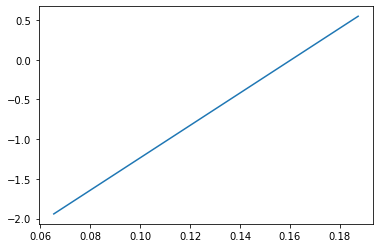

In [50]:
plt.plot(codes_pca[0], codes_pca[1])

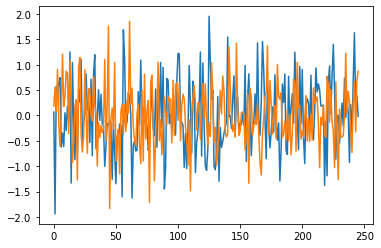

In [36]:
plt.plot(codes_pca)

In [13]:
import h5py
import torch
import time
import numpy as np

In [2]:
a = [2,3]

In [3]:
np.reshape(a, [2,1])

array([[2],
       [3]])

In [ ]:
xyz[xyz_idx[0]]

In [ ]:
code_mu.unsqueeze(0).repeat_interleave(2,dim=0).shape

In [ ]:
sdf_gt.reshape(20000)

In [ ]:
sdf_gt.reshape(10000)

In [ ]:
IPython.embed()

In [ ]:

loss_sdf, loss_rgb, loss_kl = compute_loss(pred_sdf, pred_rgb, sdf_gt.reshape(10000), rgb_gt.reshape(10000,3), threshold_precision, param)

In [ ]:
a = torch.tensor([[1,2,2],[3,4,3]])

In [ ]:
a[0]

In [ ]:
rgb_gt[:2,100:102]

In [ ]:
rgb_gt[:2,100:102].reshape(4,3)